# Trabajo Final Econometría III

Base de datos Original = http://sistemas.inec.cr/pad5/index.php/catalog/306/get-microdata

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

# To get diferent metric scores
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, roc_auc_score

%load_ext nb_black

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
)
from statsmodels.stats import contingency_tables
from scipy.stats import chi2

<IPython.core.display.Javascript object>

In [2]:
def model_performance_classification_statsmodels(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred_temp = model.predict(predictors) > threshold
    # rounding off the above values to get classes
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

<IPython.core.display.Javascript object>

In [3]:
def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("Verdaderos")
    plt.xlabel("Predicciones")

<IPython.core.display.Javascript object>

### Cargamos los datos

In [4]:
data = pd.read_spss("I Trimestre 2023 (3).sav")

<IPython.core.display.Javascript object>

In [63]:
data = data[
    [
        "Sexo",
        "Edad",
        "Seguro",
        "Regimen_pension",
        "Plan_voluntario",
        "Idioma",
        "Trabajo",
        "Zona",
        "Nivel_educativo",
        "Condicion_actividad",
        "Grupo_horas_efectivas",
        "Condicion_aseguramiento",
        "Formalidad_informalidad",
        "Rango_ingreso_bruto_total_trabaj",
        "Grupo_edad",
        "Tipo_seguro",
    ]
]

<IPython.core.display.Javascript object>

### Vemos las 5 primeras filas del dataframe

In [64]:
data.head()

,Sexo,Edad,Seguro,Regimen_pension,Plan_voluntario,Idioma,Trabajo,Zona,Nivel_educativo,Condicion_actividad,Grupo_horas_efectivas,Condicion_aseguramiento,Formalidad_informalidad,Rango_ingreso_bruto_total_trabaj,Grupo_edad,Tipo_seguro
1,0.0,55.0,Sí,Régimen de IVM de la CCSS?,0.0,0.0,1.0,1.0,6.0,1.0,3.0,1.0,0.0,1.0,3.0,...cuenta propia o voluntario?
3,1.0,36.0,Sí,Régimen de IVM de la CCSS?,0.0,0.0,0.0,1.0,6.0,1.0,2.0,1.0,1.0,3.0,2.0,...asalariado?
5,1.0,60.0,Sí,Régimen de IVM de la CCSS?,0.0,0.0,1.0,1.0,6.0,1.0,2.0,1.0,1.0,4.0,4.0,...asalariado?
6,1.0,44.0,Sí,Régimen de IVM de la CCSS?,0.0,0.0,1.0,1.0,3.0,1.0,2.0,1.0,1.0,2.0,2.0,...asalariado?
7,1.0,58.0,Sí,Régimen de IVM de la CCSS?,0.0,0.0,1.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,3.0,...cuenta propia o voluntario?


<IPython.core.display.Javascript object>

In [65]:
data.tail()

,Sexo,Edad,Seguro,Regimen_pension,Plan_voluntario,Idioma,Trabajo,Zona,Nivel_educativo,Condicion_actividad,Grupo_horas_efectivas,Condicion_aseguramiento,Formalidad_informalidad,Rango_ingreso_bruto_total_trabaj,Grupo_edad,Tipo_seguro
22875,1.0,24.0,Sí,Régimen de IVM de la CCSS?,0.0,0.0,1.0,0.0,4.0,1.0,2.0,1.0,1.0,2.0,0.0,...asalariado?
22876,1.0,25.0,Sí,Régimen de IVM de la CCSS?,0.0,0.0,1.0,0.0,3.0,1.0,2.0,1.0,1.0,2.0,1.0,...asalariado?
22880,1.0,21.0,Sí,Régimen de IVM de la CCSS?,0.0,0.0,1.0,0.0,4.0,1.0,3.0,1.0,1.0,2.0,0.0,...asalariado?
22883,1.0,25.0,Sí,Régimen de IVM de la CCSS?,0.0,0.0,1.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,...asalariado?
22889,1.0,45.0,Sí,Régimen de IVM de la CCSS?,0.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,3.0,...asalariado?


<IPython.core.display.Javascript object>

### Dimensiones del dataframe

In [66]:
data.shape

(5353, 16)

<IPython.core.display.Javascript object>

In [67]:
data.columns

Index(['Sexo', 'Edad', 'Seguro', 'Regimen_pension', 'Plan_voluntario',
       'Idioma', 'Trabajo', 'Zona', 'Nivel_educativo', 'Condicion_actividad',
       'Grupo_horas_efectivas', 'Condicion_aseguramiento',
       'Formalidad_informalidad', 'Rango_ingreso_bruto_total_trabaj',
       'Grupo_edad', 'Tipo_seguro'],
      dtype='object')

<IPython.core.display.Javascript object>

### Vemos si hay valores perdidos 

In [68]:
data.isnull().values.any()

False

<IPython.core.display.Javascript object>

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5353 entries, 1 to 22889
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Sexo                              5353 non-null   float64 
 1   Edad                              5353 non-null   float64 
 2   Seguro                            5353 non-null   category
 3   Regimen_pension                   5353 non-null   category
 4   Plan_voluntario                   5353 non-null   float64 
 5   Idioma                            5353 non-null   float64 
 6   Trabajo                           5353 non-null   float64 
 7   Zona                              5353 non-null   float64 
 8   Nivel_educativo                   5353 non-null   float64 
 9   Condicion_actividad               5353 non-null   float64 
 10  Grupo_horas_efectivas             5353 non-null   float64 
 11  Condicion_aseguramiento           5353 non-null   float64 
 

<IPython.core.display.Javascript object>

## Todas las variables son palabras por lo cúal debemos pasarlo a binarias o calificaciones numericas 

## Tipo seguro 

In [70]:
data["Tipo_seguro"].unique()

['...cuenta propia o voluntario?', '...asalariado?', '...mediante convenio como asociaciones, sindi...]
Categories (9, object): ['...asalariado?', '...cuenta propia o voluntario?', '...familiar de asegurado directo o pensionado?', '...mediante convenio como asociaciones, sindi..., ..., '..asegurado por el Estado, incluye familiar d..., '..otras formas como seguro de estudiante, de ..., '..pensionado del régimen no contributivo mont..., '..seguro privado o del extranjero?']

<IPython.core.display.Javascript object>

## Opciones seguro

In [71]:
data["Seguro"].unique()

['Sí']
Categories (2, object): ['No', 'Sí']

<IPython.core.display.Javascript object>

In [72]:
data["Trabajo"] = data["Trabajo"].replace("Sí", 1)
data["Trabajo"] = data["Trabajo"].replace(["No"], 0)
data["Trabajo"] = data["Trabajo"].astype(float)

<IPython.core.display.Javascript object>

In [73]:
data["Trabajo"].unique()

array([1., 0.])

<IPython.core.display.Javascript object>

## Lo que hice fue que Sí = 1 y No = 0, además de volver a la columna numerica

## Opciones que tiene Sexo

In [74]:
data["Sexo"].unique()

array([0., 1.])

<IPython.core.display.Javascript object>

In [75]:
data["Sexo"] = data["Sexo"].replace("Mujer", 0)
data["Sexo"] = data["Sexo"].replace("Hombre", 1)
data["Sexo"] = data["Sexo"].astype(float)

<IPython.core.display.Javascript object>

In [76]:
data["Sexo"].unique()

array([0., 1.])

<IPython.core.display.Javascript object>

## Lo que hice fue que Hombre = 1 y Mujer = 0, además de volver a la columna numerica

## Opciones que tiene Edad

In [77]:
data["Edad"].unique()

array([55., 36., 60., 44., 58., 61., 40., 38., 31., 22., 34., 26., 41.,
       29., 32., 56., 35., 30., 23., 75., 47., 42., 24., 20., 28., 39.,
       78., 52., 27., 25., 57., 53., 43., 50., 51., 19., 68., 59., 49.,
       46., 45., 33., 48., 37., 54., 72., 64., 62., 21., 63., 65., 74.,
       67., 76., 71., 70., 18., 69., 73., 66., 81., 77., 86., 80., 17.])

<IPython.core.display.Javascript object>

In [78]:
data["Edad"] = data["Edad"].replace("Menor de un año", np.nan)
data["Edad"] = data["Edad"].replace("97 años y más", np.nan)
data["Edad"] = data["Edad"].replace("Menor de 15 años con edad ignorada", np.nan)
data["Edad"] = data["Edad"].replace("Mayor de 15 años con edad ignorada", np.nan)
data["Edad"] = data["Edad"].astype(float)

<IPython.core.display.Javascript object>

In [79]:
data["Edad"].unique()

array([55., 36., 60., 44., 58., 61., 40., 38., 31., 22., 34., 26., 41.,
       29., 32., 56., 35., 30., 23., 75., 47., 42., 24., 20., 28., 39.,
       78., 52., 27., 25., 57., 53., 43., 50., 51., 19., 68., 59., 49.,
       46., 45., 33., 48., 37., 54., 72., 64., 62., 21., 63., 65., 74.,
       67., 76., 71., 70., 18., 69., 73., 66., 81., 77., 86., 80., 17.])

<IPython.core.display.Javascript object>

## Lo que hice fue quitar las observaciones con letras

## Opciones Nivel Educativo

In [80]:
data["Nivel_educativo"].unique()

array([6., 3., 2., 4., 1., 5., 0.])

<IPython.core.display.Javascript object>

In [81]:
data["Nivel_educativo"] = data["Nivel_educativo"].replace(["No especificado"], np.nan)
data["Nivel_educativo"] = data["Nivel_educativo"].replace("Ninguno", 0)
data["Nivel_educativo"] = data["Nivel_educativo"].replace("Primaria incompleta", 1)
data["Nivel_educativo"] = data["Nivel_educativo"].replace("Primaria completa", 2)
data["Nivel_educativo"] = data["Nivel_educativo"].replace("Secundaria incompleta", 3)
data["Nivel_educativo"] = data["Nivel_educativo"].replace("Secundaria completa", 4)
data["Nivel_educativo"] = data["Nivel_educativo"].replace("Universitario sin título", 5)
data["Nivel_educativo"] = data["Nivel_educativo"].replace("Universitario con título", 6)
data["Nivel_educativo"] = data["Nivel_educativo"].astype(float)

<IPython.core.display.Javascript object>

In [82]:
data["Nivel_educativo"].unique()

array([6., 3., 2., 4., 1., 5., 0.])

<IPython.core.display.Javascript object>

## Lo que hice fue darle un numero mayor conferme el grado aumentara 

## Opciones Grupo Horas Efectivas

In [83]:
data["Grupo_horas_efectivas"].unique()

array([3., 2., 0., 1.])

<IPython.core.display.Javascript object>

In [84]:
data["Grupo_horas_efectivas"] = data["Grupo_horas_efectivas"].replace(
    ["No especificado"], np.nan
)
data["Grupo_horas_efectivas"] = data["Grupo_horas_efectivas"].replace(
    "Menos de 15 horas", 0
)
data["Grupo_horas_efectivas"] = data["Grupo_horas_efectivas"].replace(
    "De 15 a 39 horas", 1
)
data["Grupo_horas_efectivas"] = data["Grupo_horas_efectivas"].replace(
    "De 40 a 48 horas", 2
)
data["Grupo_horas_efectivas"] = data["Grupo_horas_efectivas"].replace(
    "Más de 48 horas", 3
)
data["Grupo_horas_efectivas"] = data["Grupo_horas_efectivas"].astype(float)

<IPython.core.display.Javascript object>

In [85]:
data["Grupo_horas_efectivas"].unique()

array([3., 2., 0., 1.])

<IPython.core.display.Javascript object>

## Conforme más horas trabajara mayor el numero

## Opciones Formaliad e Informalidad

In [86]:
data["Formalidad_informalidad"].unique()

array([0., 1.])

<IPython.core.display.Javascript object>

In [87]:
data["Formalidad_informalidad"] = data["Formalidad_informalidad"].replace(
    ["Con empleo informal"], 0
)
data["Formalidad_informalidad"] = data["Formalidad_informalidad"].replace(
    "Con empleo formal", 1
)
data["Formalidad_informalidad"] = data["Formalidad_informalidad"].astype(float)

<IPython.core.display.Javascript object>

In [88]:
data["Formalidad_informalidad"].unique()

array([0., 1.])

<IPython.core.display.Javascript object>

## Formal = 1 , Informal = 0 

## Opciones Plan voluntario

In [89]:
data["Plan_voluntario"].unique()

array([0., 1.])

<IPython.core.display.Javascript object>

In [90]:
data["Plan_voluntario"] = data["Plan_voluntario"].replace(["No"], 0)
data["Plan_voluntario"] = data["Plan_voluntario"].replace("Sí", 1)
data["Plan_voluntario"] = data["Plan_voluntario"].astype(float)

<IPython.core.display.Javascript object>

In [91]:
data["Plan_voluntario"].unique()

array([0., 1.])

<IPython.core.display.Javascript object>

## Sí = 1, No = 0 

## Opciones de Idioma

In [92]:
data["Idioma"].unique()

array([0., 1.])

<IPython.core.display.Javascript object>

In [93]:
data["Idioma"] = data["Idioma"].replace(["No"], 0)
data["Idioma"] = data["Idioma"].replace("Sí", 1)
data["Idioma"] = data["Idioma"].astype(float)

<IPython.core.display.Javascript object>

In [94]:
data["Idioma"].unique()

array([0., 1.])

<IPython.core.display.Javascript object>

## Sí = 1, No = 0

## Opciones Zona

In [95]:
data["Zona"].unique()

array([1., 0.])

<IPython.core.display.Javascript object>

In [96]:
data["Condicion_actividad"].unique()

array([1.])

<IPython.core.display.Javascript object>

In [97]:
data["Zona"].unique()

array([1., 0.])

<IPython.core.display.Javascript object>

In [98]:
data["Zona"] = data["Zona"].replace("Rural", 0)
data["Zona"] = data["Zona"].replace("Urbana", 1)
data["Zona"] = data["Zona"].astype(float)

<IPython.core.display.Javascript object>

## Rural = 0, Urbana = 1 

## Opciones Condicion Actividad

In [99]:
data["Condicion_actividad"].unique()

array([1.])

<IPython.core.display.Javascript object>

In [100]:
data["Condicion_actividad"] = data["Condicion_actividad"].replace(
    ["Fuera de la fuerza de trabajo"], np.nan
)
data["Condicion_actividad"] = data["Condicion_actividad"].replace("Desempleado", 0)
data["Condicion_actividad"] = data["Condicion_actividad"].replace("Ocupado", 1)
data["Condicion_actividad"] = data["Condicion_actividad"].astype(float)

<IPython.core.display.Javascript object>

In [101]:
data["Condicion_actividad"].unique()

array([1.])

<IPython.core.display.Javascript object>

## Fuera de la fuerza de trabajo = No nos interesa, por ende le puse valor perdido para al final borrarlo
## Ocupado = 1, Desempleado = 0

## Opciones Condicion aseguramiento

In [102]:
data["Condicion_aseguramiento"].unique()

array([1.])

<IPython.core.display.Javascript object>

In [103]:
data["Condicion_aseguramiento"] = data["Condicion_aseguramiento"].replace(
    "No tiene seguro por trabajo", 0
)
data["Condicion_aseguramiento"] = data["Condicion_aseguramiento"].replace(
    "Tiene seguro por trabajo", 1
)
data["Condicion_aseguramiento"] = data["Condicion_aseguramiento"].astype(float)

<IPython.core.display.Javascript object>

In [104]:
data["Condicion_aseguramiento"].unique()

array([1.])

<IPython.core.display.Javascript object>

## Tiene = 1, No tiene = 0

## Rango de ingreso bruto total trabajo

In [105]:
data["Rango_ingreso_bruto_total_trabaj"].unique()

array([1., 3., 4., 2., 0.])

<IPython.core.display.Javascript object>

In [106]:
data["Rango_ingreso_bruto_total_trabaj"] = data[
    "Rango_ingreso_bruto_total_trabaj"
].replace("No especificado", np.nan)
data["Rango_ingreso_bruto_total_trabaj"] = data[
    "Rango_ingreso_bruto_total_trabaj"
].replace("No recibe ingresos", 0)
data["Rango_ingreso_bruto_total_trabaj"] = data[
    "Rango_ingreso_bruto_total_trabaj"
].replace("Menos de un salario mínimo", 1)
data["Rango_ingreso_bruto_total_trabaj"] = data[
    "Rango_ingreso_bruto_total_trabaj"
].replace("De uno a menos de dos salarios mínimos", 2)
data["Rango_ingreso_bruto_total_trabaj"] = data[
    "Rango_ingreso_bruto_total_trabaj"
].replace("De dos a menos de cinco salarios mínimos", 3)
data["Rango_ingreso_bruto_total_trabaj"] = data[
    "Rango_ingreso_bruto_total_trabaj"
].replace("Cinco salarios mínimos o más", 4)
data["Rango_ingreso_bruto_total_trabaj"] = data[
    "Rango_ingreso_bruto_total_trabaj"
].astype(float)

<IPython.core.display.Javascript object>

## Si no se especifico lo pongo como perdido 
## los demas van avanzando conforme gana mas dinero 

## Opciones grupo edad

In [107]:
data["Grupo_edad"].unique()

array([3., 2., 4., 1., 0.])

<IPython.core.display.Javascript object>

In [108]:
data["Grupo_edad"] = data["Grupo_edad"].replace("Ignorado", np.nan)
data["Grupo_edad"] = data["Grupo_edad"].replace("15 a 24 años", 0)
data["Grupo_edad"] = data["Grupo_edad"].replace("25 a 34 años", 1)
data["Grupo_edad"] = data["Grupo_edad"].replace("35 a 44 años", 2)
data["Grupo_edad"] = data["Grupo_edad"].replace("45 a 59 años", 3)
data["Grupo_edad"] = data["Grupo_edad"].replace("60 y más", 4)
data["Grupo_edad"] = data["Grupo_edad"].astype(float)

<IPython.core.display.Javascript object>

## Si se ignoro lo borro, lo demás va avanzado conforme la edad es mayor

## Veamos como quedo la base de datos

In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5353 entries, 1 to 22889
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Sexo                              5353 non-null   float64 
 1   Edad                              5353 non-null   float64 
 2   Seguro                            5353 non-null   category
 3   Regimen_pension                   5353 non-null   category
 4   Plan_voluntario                   5353 non-null   float64 
 5   Idioma                            5353 non-null   float64 
 6   Trabajo                           5353 non-null   float64 
 7   Zona                              5353 non-null   float64 
 8   Nivel_educativo                   5353 non-null   float64 
 9   Condicion_actividad               5353 non-null   float64 
 10  Grupo_horas_efectivas             5353 non-null   float64 
 11  Condicion_aseguramiento           5353 non-null   float64 
 

<IPython.core.display.Javascript object>

In [153]:
data.to_csv("datos_tratados")

<IPython.core.display.Javascript object>

In [110]:
data.dropna(inplace=True)

<IPython.core.display.Javascript object>

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5353 entries, 1 to 22889
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Sexo                              5353 non-null   float64 
 1   Edad                              5353 non-null   float64 
 2   Seguro                            5353 non-null   category
 3   Regimen_pension                   5353 non-null   category
 4   Plan_voluntario                   5353 non-null   float64 
 5   Idioma                            5353 non-null   float64 
 6   Trabajo                           5353 non-null   float64 
 7   Zona                              5353 non-null   float64 
 8   Nivel_educativo                   5353 non-null   float64 
 9   Condicion_actividad               5353 non-null   float64 
 10  Grupo_horas_efectivas             5353 non-null   float64 
 11  Condicion_aseguramiento           5353 non-null   float64 
 

<IPython.core.display.Javascript object>

In [112]:
# data.to_csv("data.csv")

<IPython.core.display.Javascript object>

In [113]:
# let's check missing values in the data again
data.isna().sum()

Sexo                                0
Edad                                0
Seguro                              0
Regimen_pension                     0
Plan_voluntario                     0
Idioma                              0
Trabajo                             0
Zona                                0
Nivel_educativo                     0
Condicion_actividad                 0
Grupo_horas_efectivas               0
Condicion_aseguramiento             0
Formalidad_informalidad             0
Rango_ingreso_bruto_total_trabaj    0
Grupo_edad                          0
Tipo_seguro                         0
dtype: int64

<IPython.core.display.Javascript object>

In [114]:
# Let's impute missing values using mean value
# data[cols] = data[cols].fillna(data[cols].mean())

<IPython.core.display.Javascript object>

In [115]:
# let's check missing values in the data again
data.isna().sum()

Sexo                                0
Edad                                0
Seguro                              0
Regimen_pension                     0
Plan_voluntario                     0
Idioma                              0
Trabajo                             0
Zona                                0
Nivel_educativo                     0
Condicion_actividad                 0
Grupo_horas_efectivas               0
Condicion_aseguramiento             0
Formalidad_informalidad             0
Rango_ingreso_bruto_total_trabaj    0
Grupo_edad                          0
Tipo_seguro                         0
dtype: int64

<IPython.core.display.Javascript object>

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5353 entries, 1 to 22889
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Sexo                              5353 non-null   float64 
 1   Edad                              5353 non-null   float64 
 2   Seguro                            5353 non-null   category
 3   Regimen_pension                   5353 non-null   category
 4   Plan_voluntario                   5353 non-null   float64 
 5   Idioma                            5353 non-null   float64 
 6   Trabajo                           5353 non-null   float64 
 7   Zona                              5353 non-null   float64 
 8   Nivel_educativo                   5353 non-null   float64 
 9   Condicion_actividad               5353 non-null   float64 
 10  Grupo_horas_efectivas             5353 non-null   float64 
 11  Condicion_aseguramiento           5353 non-null   float64 
 

<IPython.core.display.Javascript object>

### Bivariate Analysis

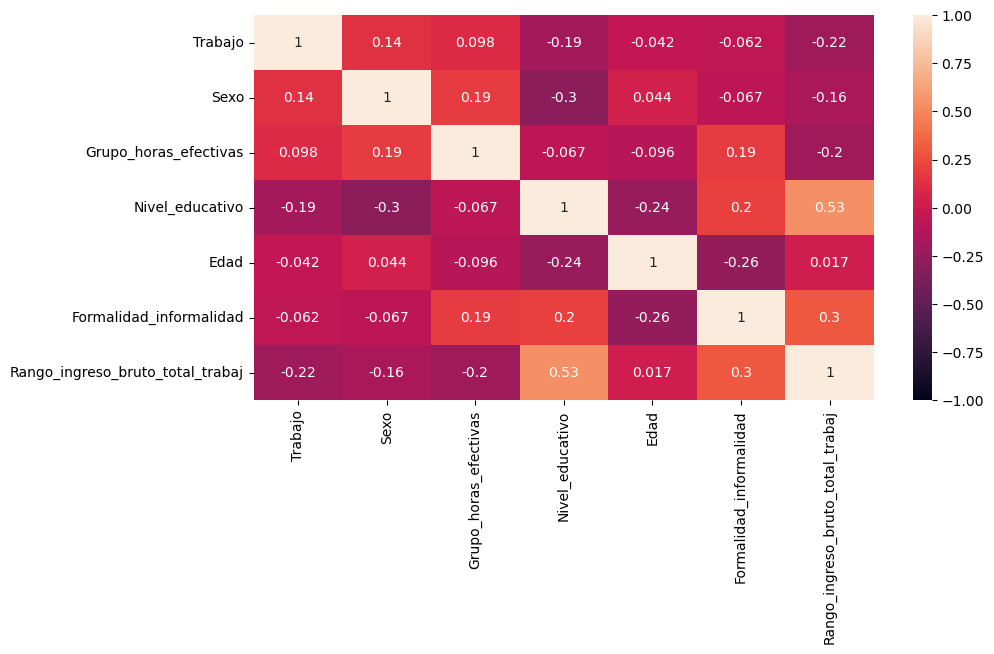

<IPython.core.display.Javascript object>

In [117]:
plt.figure(figsize=(10, 5))
sns.heatmap(
    data[
        [
            "Trabajo",
            "Sexo",
            "Grupo_horas_efectivas",
            "Nivel_educativo",
            "Edad",
            "Formalidad_informalidad",
            "Rango_ingreso_bruto_total_trabaj",
        ]
    ].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
)
plt.show()

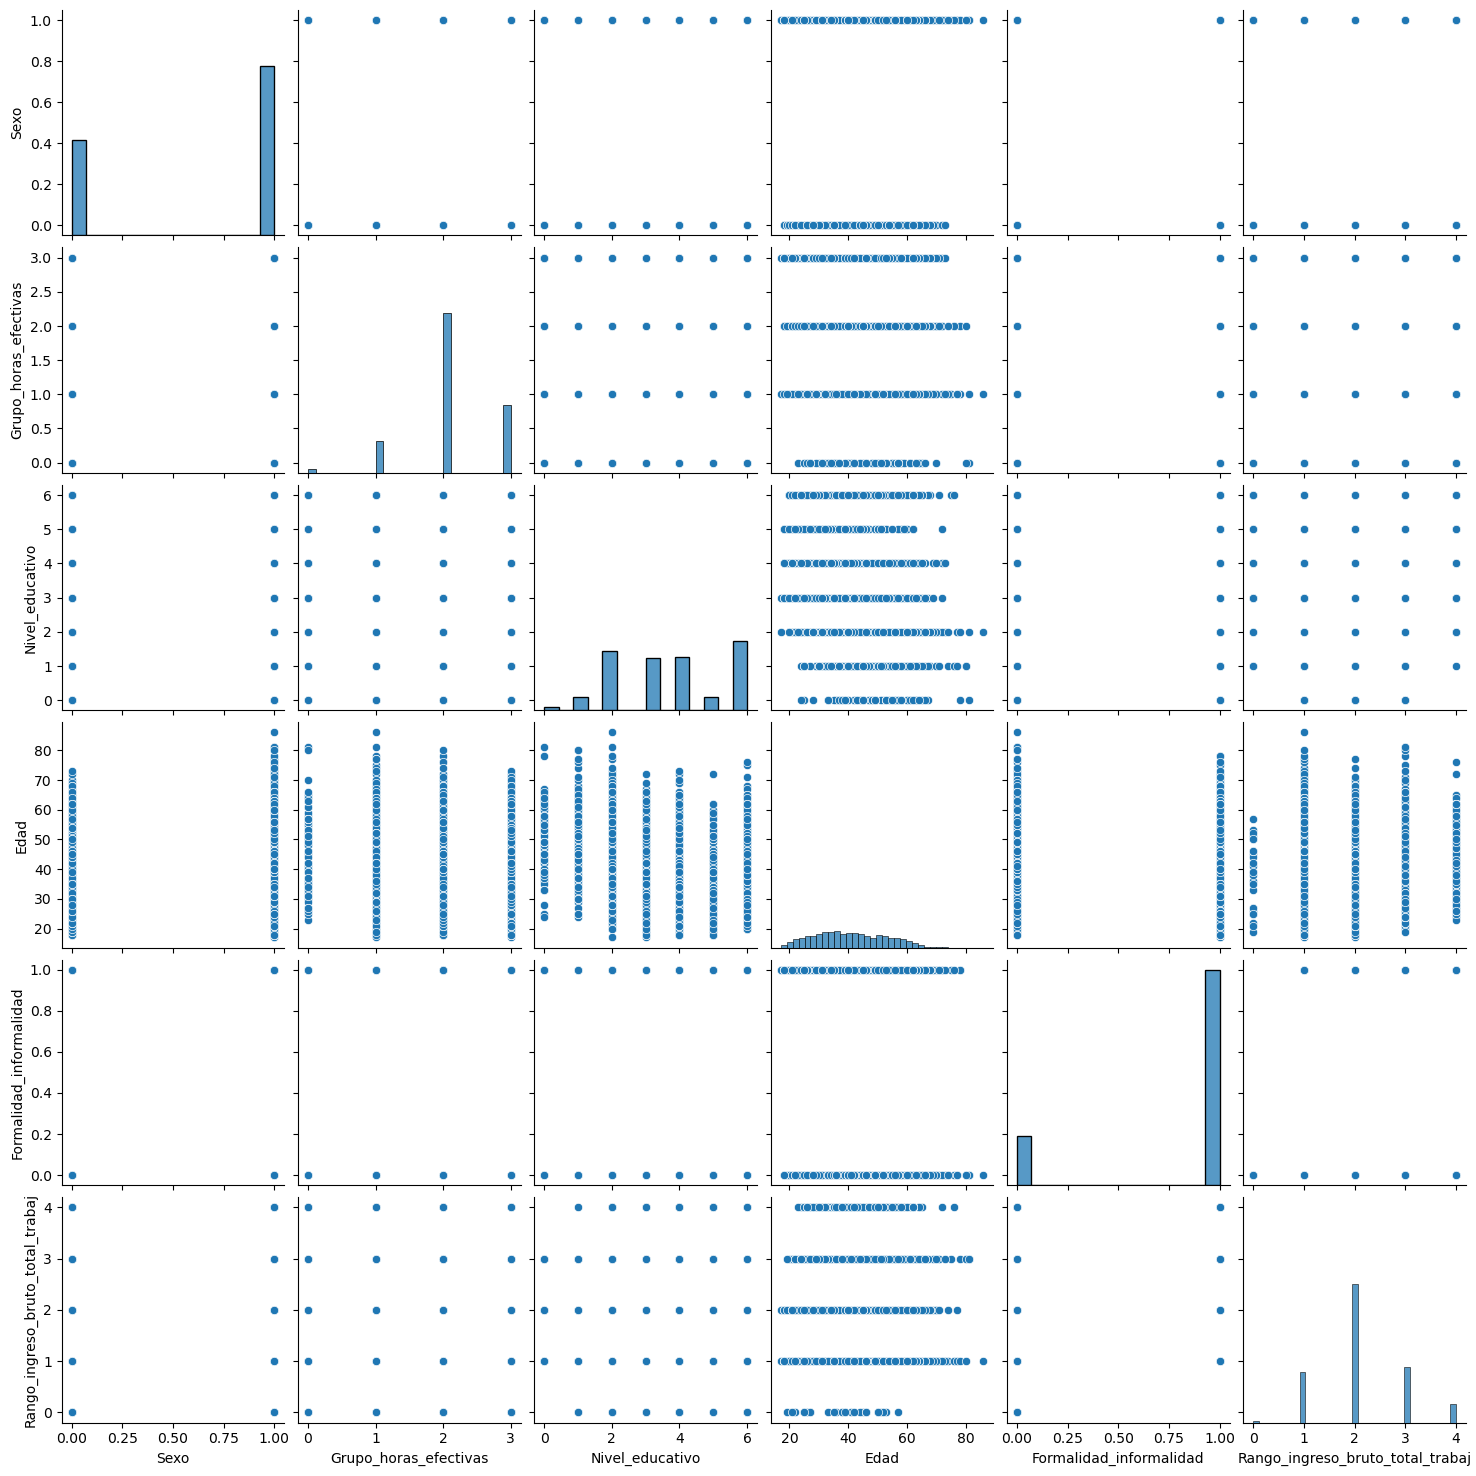

<IPython.core.display.Javascript object>

In [118]:
sns.pairplot(
    data[
        [
            "Sexo",
            "Grupo_horas_efectivas",
            "Nivel_educativo",
            "Edad",
            "Formalidad_informalidad",
            "Rango_ingreso_bruto_total_trabaj",
        ]
    ]
)
plt.show()

<Axes: ylabel='Trabajo'>

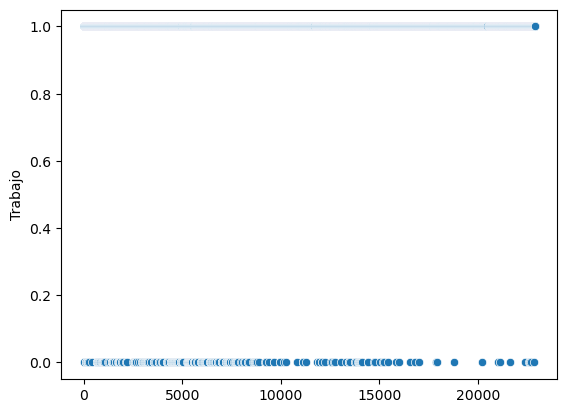

<IPython.core.display.Javascript object>

In [119]:
sns.scatterplot(data=data, x=data.index, y="Trabajo")

##  Principal Problema

In [120]:
data["Trabajo"].value_counts()

Trabajo
1.0    5012
0.0     341
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [121]:
data["Trabajo"].value_counts(1)

Trabajo
1.0    0.936297
0.0    0.063703
Name: proportion, dtype: float64

<IPython.core.display.Javascript object>

## En la base de datos casi todos estan empleado por ende emplear un 0.5 sin diferenciar va a hacer que el modelo sea malo para predecir

In [122]:
X = data[
    [
        "Sexo",
        "Grupo_horas_efectivas",
        "Nivel_educativo",
        "Edad",
        "Formalidad_informalidad",
    ]
]
Y = data["Trabajo"]

X = add_constant(X)


<IPython.core.display.Javascript object>

In [123]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5353 entries, 1 to 22889
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   const                    5353 non-null   float64
 1   Sexo                     5353 non-null   float64
 2   Grupo_horas_efectivas    5353 non-null   float64
 3   Nivel_educativo          5353 non-null   float64
 4   Edad                     5353 non-null   float64
 5   Formalidad_informalidad  5353 non-null   float64
dtypes: float64(6)
memory usage: 292.7 KB


<IPython.core.display.Javascript object>

In [124]:
Y.info()

<class 'pandas.core.series.Series'>
Index: 5353 entries, 1 to 22889
Series name: Trabajo
Non-Null Count  Dtype  
--------------  -----  
5353 non-null   float64
dtypes: float64(1)
memory usage: 83.6 KB


<IPython.core.display.Javascript object>

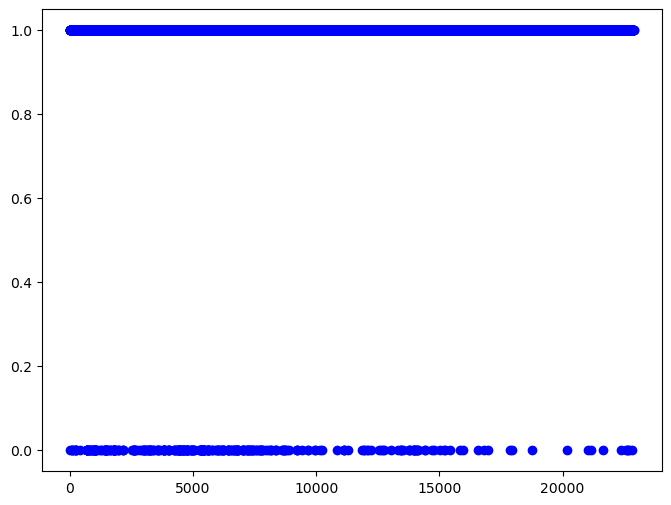

<IPython.core.display.Javascript object>

In [125]:
# Crear una figura y ejes para el gráfico
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar los datos
ax.scatter(X.index,Y, color='b', label='Datos', marker='o')


## Hacemos el modelo

In [126]:
logit = sm.Logit(Y, X)
lg = logit.fit()

Optimization terminated successfully.
         Current function value: 0.208655
         Iterations 8


<IPython.core.display.Javascript object>

In [127]:
# Vemos los resultados
print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:                Trabajo   No. Observations:                 5353
Model:                          Logit   Df Residuals:                     5347
Method:                           MLE   Df Model:                            5
Date:                Sun, 12 Nov 2023   Pseudo R-squ.:                  0.1197
Time:                        12:53:05   Log-Likelihood:                -1116.9
converged:                       True   LL-Null:                       -1268.9
Covariance Type:            nonrobust   LLR p-value:                 1.494e-63
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       5.0718      0.405     12.532      0.000       4.279       5.865
Sexo                        0.5579      0.124      4.506      0.000       0.315       0.801


<IPython.core.display.Javascript object>

## Cumple con: 
- Todas son signficativas 
- La razón de verosimilitud es significativo por ende globalmente funciona el modelo 

In [128]:
lg.params

const                      5.071802
Sexo                       0.557883
Grupo_horas_efectivas      0.566558
Nivel_educativo           -0.429344
Edad                      -0.029310
Formalidad_informalidad   -0.851287
dtype: float64

<IPython.core.display.Javascript object>

## Ahora para cambiar el límite de probabilidad se puede usar la intercección entre accuracy y recall que son criterios de información relevantes 

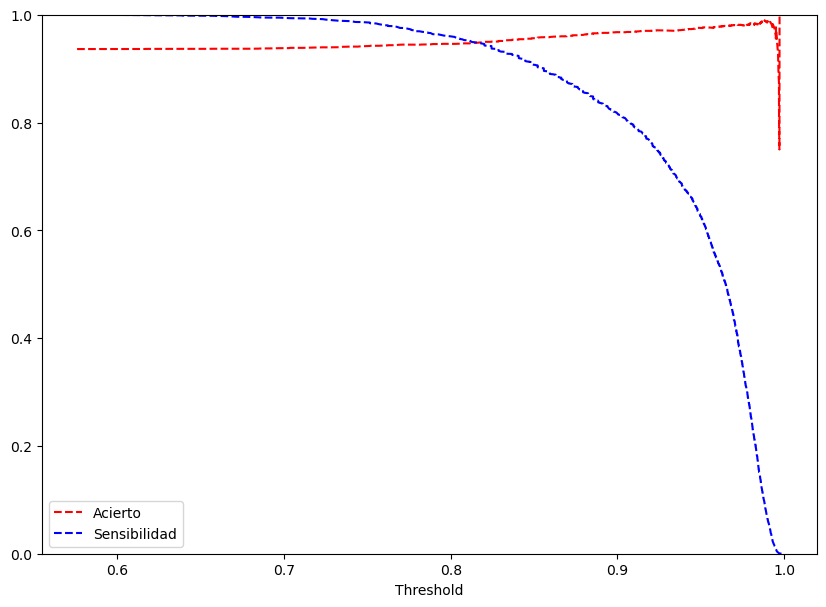

<IPython.core.display.Javascript object>

In [129]:
y_scores = lg.predict(X)
prec, rec, tre = precision_recall_curve(
    Y,
    y_scores,
)


def plot_prec_recall_vs_tresh(accuracy, recalls, thresholds):
    plt.plot(thresholds, accuracy[:-1], "r--", label="Acierto")
    plt.plot(thresholds, recalls[:-1], "b--", label="Sensibilidad")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

## El límite optimo para el la mejor predicción = 0.81

In [130]:
pred_train = lg.predict(X) > 0.81
pred_train = np.round(pred_train)

<IPython.core.display.Javascript object>

In [131]:
def HosmerLemeshow(model, Y):
    pihat = model.predict()
    pihatcat = pd.cut(
        pihat,
        np.percentile(pihat, [0, 25, 50, 75, 100]),
        labels=False,
        include_lowest=True,
    )  # here we've chosen only 4 groups
    meanprobs = [0] * 4
    expevents = [0] * 4
    obsevents = [0] * 4
    meanprobs2 = [0] * 4
    expevents2 = [0] * 4
    obsevents2 = [0] * 4
    for i in range(4):
        meanprobs[i] = np.mean(pihat[pihatcat == i])
        expevents[i] = np.sum(pihatcat == i) * np.array(meanprobs[i])
        obsevents[i] = np.sum(Y[pihatcat == i])
        meanprobs2[i] = np.mean(1 - pihat[pihatcat == i])
        expevents2[i] = np.sum(pihatcat == i) * np.array(meanprobs2[i])
        obsevents2[i] = np.sum(1 - Y[pihatcat == i])
    data1 = {"meanprobs": meanprobs, "meanprobs2": meanprobs2}
    data2 = {"expevents": expevents, "expevents2": expevents2}
    data3 = {"obsevents": obsevents, "obsevents2": obsevents2}
    m = pd.DataFrame(data1)
    e = pd.DataFrame(data2)
    o = pd.DataFrame(data3)

    # The statistic for the test, which follows, under the null hypothesis,
    # The chi-squared distribution with degrees of freedom equal to amount of groups - 2. Thus 4 - 2 = 2
    tt = sum(sum((np.array(o) - np.array(e)) ** 2 / np.array(e)))
    pvalue = 1 - chi2.cdf(tt, 2)
    return pd.DataFrame(
        [[chi2.cdf(tt, 2).round(2), pvalue.round(2)]], columns=["Chi2", "p - value"]
    )

<IPython.core.display.Javascript object>

## Realizamos el Hosmer Lemeshow 

In [132]:
HosmerLemeshow(lg, Y)

,Chi2,p - value
0,0.87,0.13


<IPython.core.display.Javascript object>

### - Cumple tanto en python como en eviews

## Realizamos una matriz de correctos e incorrectos 

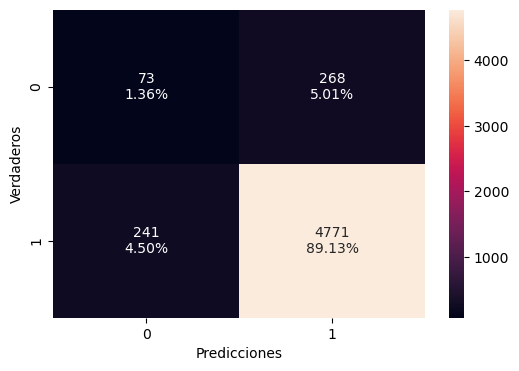

<IPython.core.display.Javascript object>

In [133]:
confusion_matrix_statsmodels(lg, X, Y, threshold=0.81)

In [134]:
print("Accuracy: ", accuracy_score(Y, pred_train))

Accuracy:  0.9049131328227162


<IPython.core.display.Javascript object>

In [135]:
print("Recall  o sensibilidad : ", recall_score(Y, pred_train))

Recall  o sensibilidad :  0.9519154030327215


<IPython.core.display.Javascript object>

## Una muy buena sensibilidad 

In [136]:
confusion = confusion_matrix(Y, pred_train)
VN = confusion[0, 0]
FP = confusion[0, 1]

# Calcular la especificidad
especificidad = VN / (VN + FP)

print("Especificidad:", especificidad)

Especificidad: 0.21407624633431085


<IPython.core.display.Javascript object>

## Una mala especificidad 

### Revisamos Multicolinealidad

In [139]:
# let's check the VIF of the predictors
vif_series = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
    index=X.columns,
    dtype=float,
)
print("VIF values: \n\n{}\n".format(vif_series))

VIF values: 

const                      43.997494
Sexo                        1.136491
Grupo_horas_efectivas       1.088721
Nivel_educativo             1.192944
Edad                        1.119075
Formalidad_informalidad     1.137304
dtype: float64



<IPython.core.display.Javascript object>

**Odds Ratio de los coeficientes**

In [140]:
# Le sacamos antilogratimo
odds = np.exp(lg.params)

# Los ponemos en un dataframe
pd.DataFrame(odds, X.columns, columns=["odds"]).T

,const,Sexo,Grupo_horas_efectivas,Nivel_educativo,Edad,Formalidad_informalidad
odds,159.461396,1.74697,1.76219,0.650936,0.971115,0.426865


<IPython.core.display.Javascript object>

**Percentage change in odds**

In [141]:
# Lo ponemos en porcentaje
perc_change_odds = (np.exp(lg.params) - 1) * 100

# Lo ponemos en dataframe
pd.DataFrame(
    perc_change_odds, X.columns, columns=["Cambio% en la razón de probabilidad"]
).T

,const,Sexo,Grupo_horas_efectivas,Nivel_educativo,Edad,Formalidad_informalidad
Cambio% en la razón de probabilidad,15846.139629,74.697037,76.219039,-34.906386,-2.88846,-57.313474


<IPython.core.display.Javascript object>

In [142]:
Criterios_información = model_performance_classification_statsmodels(
    lg, X, Y, threshold=0.81
)
print("Como se comporta:")
Criterios_información

Como se comporta:


,Accuracy,Recall,Precision,F1
0,0.904913,0.951915,0.946815,0.949358


<IPython.core.display.Javascript object>

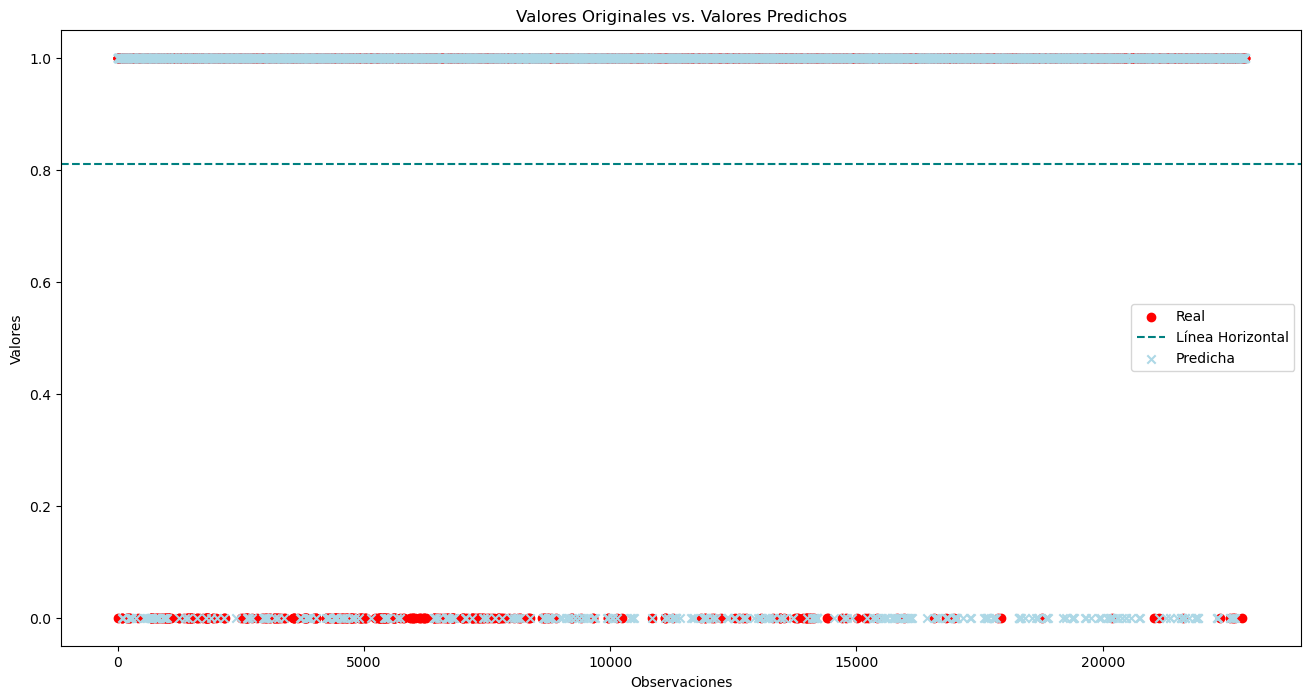

<IPython.core.display.Javascript object>

In [143]:
df = {"y_real": Y, "y_predicha": pred_train}
df = pd.DataFrame(df)

# Crear una figura y ejes para el gráfico
fig, ax = plt.subplots(figsize=(16, 8))

# Graficar los valores originales vs. los valores predichos
ax.scatter(df.index, df["y_real"], color="red", label="Real", marker="o")
ax.axhline(y=0.81, color="teal", linestyle="--", label="Línea Horizontal")
ax.scatter(df.index, df["y_predicha"], color="lightblue", label="Predicha", marker="x")
ax.set_xlabel("Observaciones")
ax.set_ylabel("Valores")
ax.set_title("Valores Originales vs. Valores Predichos")
ax.legend(loc="best")

# Mostrar la figura
plt.show()